# Fibrotic Memory Fibroblasts- Scimlarity Search

The goal here is two fold 
1. Cell Type prediction using Scimilarity
    a. We want to see how the algorithim assign cell labels using a massive embedding
    
2. Cell Query
    a. We do indeed see memory cells in our multiome data, can we use SCimilarity to find other datasets where they exsist.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import scimilarity
print(scimilarity.__version__)

0.0.69


In [2]:
import os

import anndata
import numpy as np
#import pandas as pd
import scanpy as sc

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from scimilarity import ModelPath, CellQuery, CellAnnotation, Interpreter
from scimilarity.utils import align_dataset, lognorm_counts
from scimilarity.visualizations import hits_heatmap
from scipy.spatial.distance import cdist

sc.set_figure_params(dpi=100, dpi_save=200)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [5]:
def get_study(study, data_path):
    data = {}
    samples = os.listdir(os.path.join(data_path, study))
    for sample in samples:
        file = os.path.join(data_path, study, sample, sample + ".h5ad")
        if os.path.exists(file):
            data[sample] = anndata.read_h5ad(file)
    return anndata.concat(data.values(), join="outer", label="sample", keys=data.keys())

## Model Path

In [3]:
model_path = ModelPath.model_latest
print(model_path)
#model_path = "/gstore/data/omni/scdb/models/prd/model_2023_04_rep0"
#print(model_path)

/gstore/data/omni/scdb/models/human/model_2023_04_rep0


## Load the data

In [4]:
from pydsdb import get_experiment

AttributeError: module 'anndata.compat' has no attribute 'Literal'

In [ ]:
processed_file = "/gstore/scratch/u/lucast3/fibroticmemory/data/NGS4921_sCell.h5ad"
if os.path.exists(processed_file): # if a processed dataset exists load that instead
    data = anndata.read_h5ad(processed_file)
else:
    from pydsdb import get_experiment
    se = get_experiment("DS000016544","multiome")
    data = se.toAnnData()
    del(se)
print(data)


#### Process the data: filter, normalize, gene selection, pca, umap, clustering

In [8]:
if not os.path.exists(processed_file):
    # filter
    data.var["mt"] = data.var_names.str.startswith("MT-")  # annotate the group of mitochondrial genes as 'mt'
    qcs = sc.pp.calculate_qc_metrics(data, qc_vars=["mt"], layer="counts")
    data = data[qcs[0]["pct_counts_mt"] < 30].copy()
    
    
    # log normalize
    data = lognorm_counts(data) # mandatory as the model uses lognorm tp10k

    # save the processed dataset in case of rerunning so we can skip reprocessing it again
    data.write(processed_file)
print(data)

AnnData object with n_obs × n_vars = 28351 × 36438
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'Gex_RiboRatio', 'DoubletScore', 'DoubletEnrichment', 'Clusters_ATAC', 'Clusters_RNA', 'Clusters_Combined', 'ReadsInPeaks', 'FRIP', 'Group', 'Treatment', 'Module.PanFibroblast', 'Module.Adventitial', 'Module.Alveolar', 'Module.Myofibroblast', 'Module.SMC', 'Module.Pericyte', 'Module.Lipofibroblast', 'Module.Mesothelial', 'Module.Collagens', 'Module.TGFb', 'Module.Fibrosis', 'Module.CSF', 'Module.gp130', 'celltype', 'Clusters_Combined_Harmony', 'PanFibroblast', 'Adventitial', 'Alveolar', 'Myofibroblast', 'SMC', 'Pericyte', 'Lipofibroblast', 'Mesothelial', 'Collagens', 'TGFb', 'Fibrosis', 'CSF', 'gp130', 'Clusters_Combined_Harmony_res0.05', 'Clusters_Combined_Harmony_res0.1', 'Clusters_Combined_

## Celltype prediction

#### Load the model for cell annotation

In [9]:
ca = CellAnnotation(model_path=model_path)

#### Annotate the dataset with predicted celltypes

*Description of outputs*

X_scimilarity: embeddings from the model, which can be used to generate umaps in lieu of PCA and is in theory general across datasets
    
celltype_hint: celltype label predictions.

celltype_hits: the distribution of celltypes in k=50 nearest neighbors

min_dist: the minimum distance within k=50 nearest neighbors

*Note*: for more fine grained control see the method "get_predictions" in the CellAnnotation class

In [10]:
data = ca.annotate_dataset(data)
print(data)

Get nearest neighbors finished in: 0.025340024630228677 min


100%|██████████| 28351/28351 [00:15<00:00, 1776.87it/s]


AnnData object with n_obs × n_vars = 28351 × 36438
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRatio', 'Gex_RiboRatio', 'DoubletScore', 'DoubletEnrichment', 'Clusters_ATAC', 'Clusters_RNA', 'Clusters_Combined', 'ReadsInPeaks', 'FRIP', 'Group', 'Treatment', 'Module.PanFibroblast', 'Module.Adventitial', 'Module.Alveolar', 'Module.Myofibroblast', 'Module.SMC', 'Module.Pericyte', 'Module.Lipofibroblast', 'Module.Mesothelial', 'Module.Collagens', 'Module.TGFb', 'Module.Fibrosis', 'Module.CSF', 'Module.gp130', 'celltype', 'Clusters_Combined_Harmony', 'PanFibroblast', 'Adventitial', 'Alveolar', 'Myofibroblast', 'SMC', 'Pericyte', 'Lipofibroblast', 'Mesothelial', 'Collagens', 'TGFb', 'Fibrosis', 'CSF', 'gp130', 'Clusters_Combined_Harmony_res0.05', 'Clusters_Combined_Harmony_res0.1', 'Clusters_Combined_

#### Visualize the predictions and stats for QC

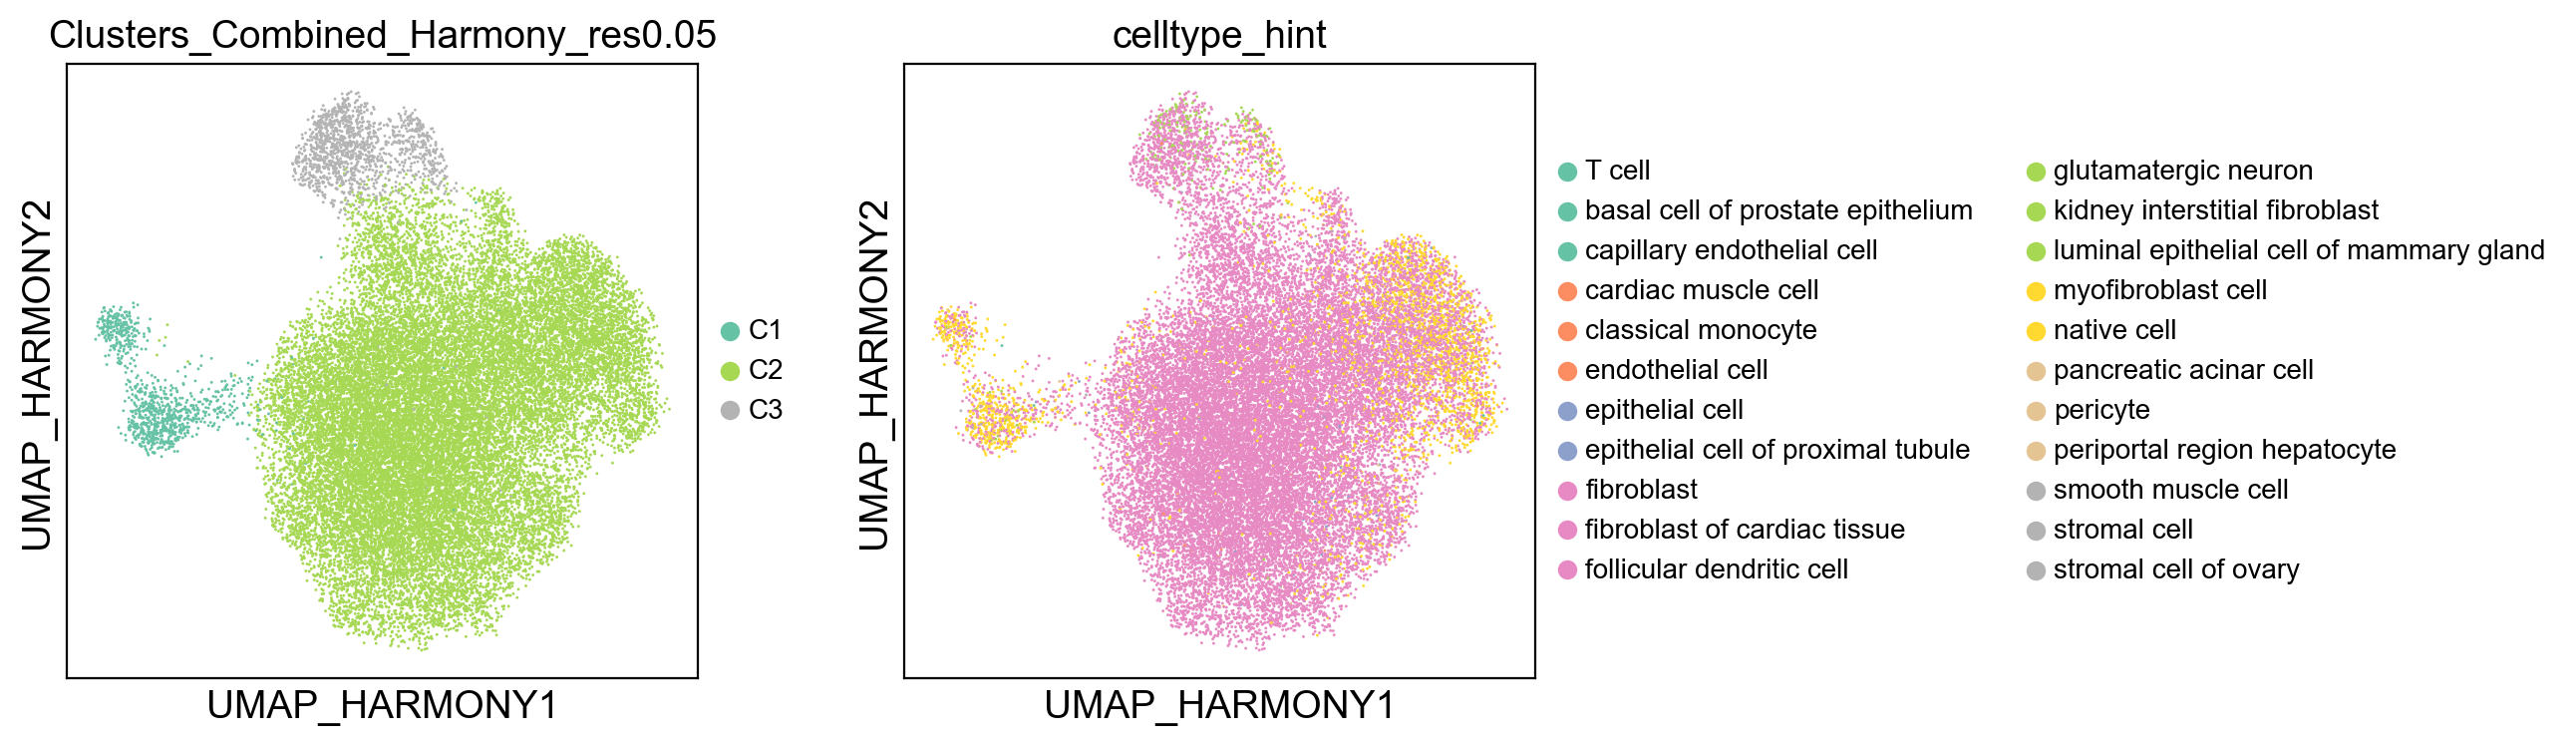

In [11]:
sc.pl.embedding(data,basis="UMAP_HARMONY", color=["Clusters_Combined_Harmony_res0.05", "celltype_hint"], palette="Set2", legend_fontsize=10)
#sc.pl.embedding(data,basis="UMAP_HARMONY", color="min_dist", palette="Set2", legend_loc="on data", legend_fontsize=3)

## Update dataset on Datasetdb

In [6]:
from gpauth import GPAuth
from multiassayexperiment import MultiAssayExperiment
from pandas import concat
from pydsdb import (
    Upload,
    add_metadata,
    create_permissions_info,
    create_scr_metadata,
    get_dataset,
)
import pydsdb 

In [13]:
# Write back to file with Scimilarity results
#data.write(processed_file)

In [14]:
#mae = get_dataset("DS000016544",version=6)

In [15]:
# Convert data back to SCE
import singlecellexperiment as sce
#sExpt = sce.fromAnnData(data)


In [16]:
#from pydsdb import ALT_SEP

In [17]:
#alt_exp = f"multiome{ALT_SEP}ArchR GeneScore Matrix"

#ann_data = get_dataset("DS000016544", alt_exp)

In [18]:
#mae.experiments['multiome'] = sExpt

In [19]:
#dsid= "DS000016544"
#auth = GPAuth("Alpha19oh6")

In [20]:
#permissions = create_permissions_info()
#dsid, version = Upload(mae,file_size_limit="8 GiB").submit(auth, permissions, dsid,mode="sts:boto3")

## Cell Query

#### Load the model for cell query

In [ ]:
cq = CellQuery(model_path=model_path)

In [ ]:
cq.cell_metadata.columns

##### The full metadata for every cell is accessible as a pandas dataframe

In [ ]:
cq.cell_metadata

##### The embeddings for every cell is accessible as a tiledb array via a get precomputed embeddings helper function

In [24]:
print(cq.cell_embedding.shape)
cell_idx = [1, 10, 100]
cell_embeddings = cq.get_precomputed_embeddings(cell_idx)

(23381150, 128)


#### Search for cells similar to centroid of interest

**Description of inputs**

k: the number of nearest neighbors

max_dist: instead of using k, assume k = 100000, then filter for cells that are within max_dist of the query.

**Description of outputs**

centroid_embeddings: np.ndarray. A 2D numpy array of the log normalized (1e4) cluster centroid embeddings.
    
cluster_idx: list. A list of cluster labels corresponding to the order returned in centroids.

nn_idxs: Dict[str, np.ndarray]. A 2D numpy array of nearest neighbor indices [num_cells x k]. Essentially your hits list.

nn_dists: Dict[str, np.ndarray]. A 2D numpy array of nearest neighbor distances [num_cells x k]. The distance between your hits to the query.

all_metadata: pd.DataFrame. A pandas dataframe containing cell metadata for nearest neighbors for all centroids.

##### Search by exactly k nearest neighbor hits:

In [25]:
help(cq.gather_cells_by_df)

Help on method gather_cells_by_df in module scimilarity.cell_query:

gather_cells_by_df(cells_df: 'pandas.DataFrame', data_path: dict = {'train': '/gstore/data/omni/scdb/cleaned_zarrs/train', 'test': '/gstore/data/omni/scdb/cleaned_zarrs/test', 'unlabeled': '/gstore/data/omni/scdb/individual_anndatas'}, obs_fields: List[str] = ['study', 'sample', 'data_type', 'prediction', 'tissue', 'disease', 'author_label'], get_counts: bool = True, disable_tqdm: bool = False) -> 'anndata.AnnData' method of scimilarity.cell_query.CellQuery instance
    Gather cells based on pandas DataFrame information.
    
    Parameters
    ----------
    cells_df: pandas.DataFrame
        A pandas dataframe containing columns: study, sample, and index.
        Where index is the cell query index (i.e. from cq.cell_metadata).
    data_path: dict, default: ModelPath.data_latest
        A dictionary of data paths to the various data.
    obs_fields: List[str], default: ["study", "sample", "data_type", "prediction", 

In [26]:
centroid_embeddings, cluster_idx, nn_idxs, nn_dists, all_metadata = cq.search_cluster_centroids(data, "Clusters_Combined_Harmony_res0.05", k=10000)
print(cluster_idx)
print(len(all_metadata))

['C3', 'C2', 'C1']
30000


#### Compile sample level summary

In [27]:
sample_metadata = {}
for i in cluster_idx:
    sample_metadata[i] = cq.compile_sample_metadata(nn_idxs[i])

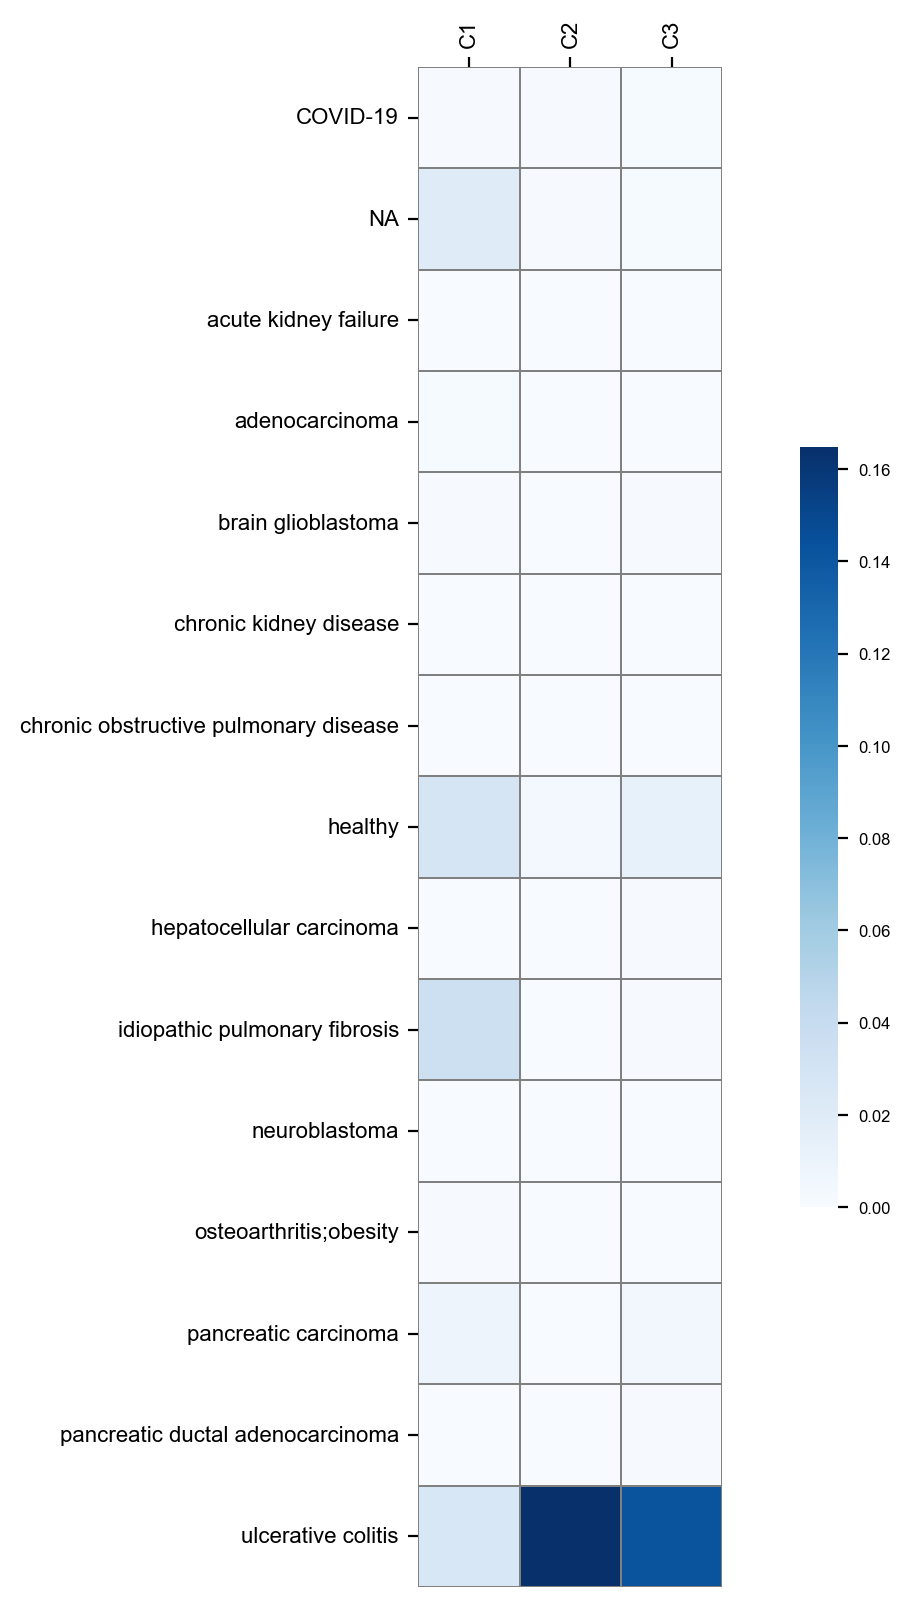

In [28]:
hits_heatmap(sample_metadata, "Clusters_Combined_Harmony_res0.05", "disease", count_type="fraction")

#### Compile study level summary

In [29]:
studies_summary = {}
for i in cluster_idx:
    studies_summary[i] = cq.groupby_studies(sample_metadata[i])

In [31]:
import pandas as pd

In [32]:
min_cells_per_study = 10
for cluster in studies_summary:
    display(cluster)
    pd.set_option("display.max_rows", 25)
    summary = studies_summary[cluster]
    display(summary.loc[summary["cells"] > min_cells_per_study].sort_values(by="cells", ascending=False))

'C3'

,tissue,disease,study,cells,fraction
12,colon,ulcerative colitis,GSE152999,7412,0.042485
11,colon,healthy,GSE152999,2332,0.013367
6,bone tissue,NA,GSE149201,56,0.000621
27,lung,idiopathic pulmonary fibrosis,DS000011735,42,0.000149
0,NA,NA,GSE157773,31,0.000679
10,central nervous system,NA,GSE146373,15,0.013043
23,lung,COVID-19,covid,13,0.000096


'C2'

,tissue,disease,study,cells,fraction
2,colon,ulcerative colitis,GSE152999,9682,0.055496
1,colon,healthy,GSE152999,158,0.000906
0,bone tissue,NA,GSE149201,77,0.000853
4,lung,COVID-19,covid,32,0.000237
6,lung,healthy,625f6bf4-2f33-4942-962e-35243d284837,19,0.000465
3,left lung,NA,ENCODE,16,0.000010
7,lung,idiopathic pulmonary fibrosis,DS000011735,13,0.000046


'C1'

,tissue,disease,study,cells,fraction
0,NA,NA,GSE157773,2811,0.061610
27,lung,healthy,GSE137026,1403,0.037327
3,amniotic fluid,healthy,GSE161066,1379,0.107332
29,lung,idiopathic pulmonary fibrosis,GSE137026,1318,0.035065
14,colon,ulcerative colitis,GSE152999,1309,0.007503
36,skin of body,healthy,GSE154359,1068,0.048758
5,bone marrow,NA,GSE162692,171,0.012024
31,lung,idiopathic pulmonary fibrosis,GSE166037,150,0.027422
10,central nervous system,NA,GSE146373,107,0.093043
13,colon,healthy,GSE152999,87,0.000499


#### Gather cells from search results
Gathering can be slow depending on the number of cells and across how many studies

##### Gather cells based on nearest neighbor indices

In [33]:
# First lets save metadata for reference
all_metadata.to_csv('/gstore/scratch/u/lucast3/fibroticmemory/sCimilarityCells.csv')

all_metadata.head()
        

,index,study,sample,prediction,fm_signature_score,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,prediction_nn_dist,...,xenograft,tissue,cell_line_cleaned,disease,FACS_sort,sex_cleaned,author_label,embedding_idx,query_nn_dist,centroid
0,1365384,GSE152999,GSM4632831,fibroblast,-0.321190,3542.0,8500.0,27.0,0.317647,0.017942,...,False,colon,NA,ulcerative colitis,NA,NA,NA,0,0.020101,C3
1,1368516,GSE152999,GSM4632831,fibroblast,0.036714,4875.0,12786.0,37.0,0.289379,0.014547,...,False,colon,NA,ulcerative colitis,NA,NA,NA,0,0.020106,C3
2,1361331,GSE152999,GSM4632831,fibroblast,-0.095597,4289.0,11510.0,29.0,0.251955,0.025182,...,False,colon,NA,ulcerative colitis,NA,NA,NA,0,0.020330,C3
3,1362775,GSE152999,GSM4632831,fibroblast,-0.261654,5848.0,20455.0,37.0,0.180885,0.027126,...,False,colon,NA,ulcerative colitis,NA,NA,NA,0,0.021107,C3
4,1371645,GSE152999,GSM4632831,fibroblast,-0.174006,3583.0,7829.0,23.0,0.293780,0.013777,...,False,colon,NA,ulcerative colitis,NA,NA,NA,0,0.021611,C3


In [34]:
nn_idxs

{'C3': [array([1365384, 1368516, 1361331, ..., 1364893, 1362311, 1335630],
        dtype=uint64)],
 'C2': [array([1390437, 1366026, 1368847, ..., 1382867, 1373932, 1380780],
        dtype=uint64)],
 'C1': [array([  77307, 1368442, 1468021, ..., 1367976, 1362334, 1362592],
        dtype=uint64)]}

In [1]:
search_results_C3 = cq.gather_cells_by_nn_idx(nn_idxs['C3'])
print(search_results_C3)

NameError: name 'cq' is not defined

In [ ]:
search_results_C2 = cq.gather_cells_by_nn_idx(nn_idxs['C2'])
print(search_results_C2)

In [ ]:
search_results_C1 = cq.gather_cells_by_nn_idx(nn_idxs['C1'])
print(search_results_C1)

##### Gather cells based on the all_metadata dataframe, which will be for all clusters

search_results = cq.gather_cells_by_nn_idx(nn_idxs['C3'])
print(search_results)

In [ ]:
search_results = cq.gather_cells_by_df(all_metadata)
print(search_results)

## Examine a target dataset of interest

In [ ]:
target_study = "GSE132771"
processed_file = f"/gstore/data/omni/scdb/scratch/{target_study}.h5ad"
if os.path.exists(processed_file): # if a processed dataset exists load that instead
    target_data = anndata.read_h5ad(processed_file)
else:
    data_path = "/gstore/data/omni/scdb/individual_anndatas"
    target_data = get_study(target_study, data_path)
print(target_data)

In [ ]:
if not os.path.exists(processed_file):
    sc.pp.filter_cells(target_data, min_genes=400)
    target_data = lognorm_counts(target_data) # mandatory as the model uses lognorm tp10k
    sc.pp.highly_variable_genes(target_data)
    sc.tl.pca(target_data)
    sc.pp.neighbors(target_data, use_rep='X_pca')
    sc.tl.umap(target_data)
    sc.tl.leiden(target_data, resolution=1.7)
    target_data.write(processed_file) # save the processed dataset in case of rerunning so we can skip reprocessing it again
print(target_data)

In [ ]:
gois = ["TREM2", "GPNMB", "SPP1", "CCL18", "MMP9", "CTSK", "APOE", "CHIT1", "LIPA", "CHI3L1", "CD14", "APOC1"]
sc.tl.score_genes(target_data, gois)

In [ ]:
sc.pl.umap(target_data, color=["leiden_labels", "score"], palette="Set2", legend_loc="on data", legend_fontsize=4)

#### Predict celltypes in the target dataset

In [ ]:
target_data = ca.annotate_dataset(target_data)
print(target_data)

In [ ]:
sc.pl.umap(target_data, color=["leiden_labels", "celltype_hint"], palette="Set2", legend_loc="on data", legend_fontsize=3)
sc.pl.umap(target_data, color="min_dist", palette="Set2", legend_loc="on data", legend_fontsize=3)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, data=target_data.obs, x="leiden_labels", y="min_dist", hue="leiden_labels", fliersize=1, dodge=False)
plt.tick_params(axis="x", which="major", labelsize=8, labelrotation=90)
ax.get_legend().remove()

#### Calculate similarity between cells in the target dataset and the centroid of the cluster of interest

#### Calculate similarity between cells in the target dataset and the centroid of the cluster of interest

In [ ]:
for i, c in enumerate(centroid_embeddings):
    j = cluster_idx[i]
    target_data.obs[f"centroid_sim_{j}"] = 1.0 / cdist(c.reshape(1,-1), target_data.obsm["X_scimilarity"], metric="cosine").flatten()
print(target_data)

#### Visualize similarity of cells in target dataset to the centroid of the cluster of interest

In [ ]:
for i in range(centroid_embeddings.shape[0]):
    j = cluster_idx[i]
    sc.pl.umap(target_data, title=f"centroid_{j}", color=[f"centroid_sim_{j}"], cmap="YlOrRd", vmax=250)

In [ ]:
sc.tl.score_genes(target_data, gois)
sc.pl.umap(target_data, color=["score"], cmap="YlOrRd")

#### Extract the cells that are similar to the centroid of the cluster of interest

## Example analysis using the model embedding as the low dimensional representation